---
# Requirements
---

In [2]:
!pip install "tensorflow-gpu>=1.15.2,<2.0" ampligraph

     |████████████████████████████████| 411.0 MB 26 kB/s 
     |████████████████████████████████| 168 kB 48.0 MB/s 
     |████████████████████████████████| 20.1 MB 35.2 MB/s 
     |████████████████████████████████| 2.9 MB 26.2 MB/s 
     |████████████████████████████████| 503 kB 46.1 MB/s 
     |████████████████████████████████| 3.8 MB 30.0 MB/s 
     |████████████████████████████████| 50 kB 2.6 MB/s 
     |████████████████████████████████| 6.4 MB 26.2 MB/s 
     |████████████████████████████████| 482 kB 44.2 MB/s 
     |████████████████████████████████| 64 kB 2.2 MB/s 
     |████████████████████████████████| 2.7 MB 25.8 MB/s 
     |████████████████████████████████| 120 kB 45.5 MB/s 
     |████████████████████████████████| 561 kB 43.9 MB/s 
     |████████████████████████████████| 64 kB 2.2 MB/s 
     |████████████████████████████████| 73 kB 1.5 MB/s 
     |████████████████████████████████| 41 kB 538 kB/s 
     |████████████████████████████████| 68 kB 5.7 MB/s 
     |███████████████████

In [3]:
import numpy as np
import pandas as pd
import ampligraph

ampligraph.__version__

'1.4.0'

In [4]:
import tensorflow as tf

tf.test.is_gpu_available()

True

# Create knoledge graph


In [5]:
import requests

url = 'https://gist.github.com/kiarro/6cf6891fc9b702c19f9b1a676299a71f/raw'

data = requests.get(url).content

print(data[:10000])

b'@prefix : <http://www.semanticweb.org/owl/owlapi/turtle#> .\n@prefix owl: <http://www.w3.org/2002/07/owl#> .\n@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .\n@prefix xml: <http://www.w3.org/XML/1998/namespace> .\n@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .\n@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .\n@prefix plants: <http://www.semanticweb.org/yuri/ontologies/2022/1/plants-2#> .\n@base <http://www.semanticweb.org/yuri/ontologies/2022/1/plants-2> .\n\n<http://www.semanticweb.org/yuri/ontologies/2022/1/plants-2> rdf:type owl:Ontology .\n\n\n#################################################################\n#\n#    Object Properties\n#\n#################################################################\n\n\n###  http://www.semanticweb.org/yuri/ontologies/2022/1/plants-2#acidity\n\nplants:acidity rdf:type owl:ObjectProperty ;\n               \n               rdfs:domain plants:Soil ;\n               \n               rdfs:subPropertyOf plants:soilProperty 

In [6]:
from rdflib import URIRef, BNode, Literal, Namespace, Graph

g = Graph()

g.parse(url, format="turtle")

<Graph identifier=N7122fc6518b943fca00491bc54031bbd (<class 'rdflib.graph.Graph'>)>

In [7]:
triples = []
for s, p, o in g:
    s1 = s.split('#')
    if len(s1)>1:
        s1 = s1[1]
    else:
        s1 = s1[0]
    
    p1 = p.split('#')
    if len(p1)>1:
        p1 = p1[1]
    else:
        p1 = p1[0]
    
    o1 = o.split('#')
    if len(o1)>1:
        o1 = o1[1]
    else:
        o1 = o1[0]
    triples.append((s1,p1,o1))

In [8]:
print(triples[:10])


[('HeightPlant_Corylopsis1', 'heightMeasurement', 'м'), ('HeightPlant_Maxillaria1', 'heght_of_plant', 'Plant_Maxillaria'), ('FlowerPlant_Dentaria', 'type', 'NamedIndividual'), ('HeightPlant_Zygadenus2', 'heght_of_plant', 'Plant_Zygadenus'), ('Plant_Haworthia', 'type', 'NamedIndividual'), ('Plant_Saponaria', 'nameRu', 'Мыльнянка'), ('HeightPlant_Dodecatheon1', 'heightDescription', 'низкое'), ('HeightPlant_Dimorphoteca1', 'type', 'NamedIndividual'), ('HeightPlant_Lysimachia1', 'type', 'NamedIndividual'), ('ClimateForPlant_Echinocactus', 'minTemperature', '8')]


In [9]:
import pandas as pd

triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
# triples_df[(triples_df.subject=="ClimateForPlant_Opuntia") | (triples_df.object=="ClimateForPlant_Opuntia")]
triples_df[(triples_df.predicate=='a') | (triples_df.predicate=='type')]

,subject,predicate,object
2,FlowerPlant_Dentaria,type,NamedIndividual
4,Plant_Haworthia,type,NamedIndividual
7,HeightPlant_Dimorphoteca1,type,NamedIndividual
8,HeightPlant_Lysimachia1,type,NamedIndividual
13,HeightPlant_Oxalis1,type,NamedIndividual
...,...,...,...
14506,HeightPlant_Cotinus2,type,Height
14508,Plant_Galanthus,type,Plant
14509,FlowerPlant_Aglaonema,type,FlowerPlant
14511,FlowerPlant_Aruncus,type,NamedIndividual


# Clusterization


In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
plants = triples_df[(triples_df.predicate=='type') & (triples_df.object=='Plant')].subject.values

In [12]:
from ampligraph.latent_features import ComplEx

model = ComplEx(batches_count=50,
                epochs=300,
                k=100,
                eta=20,
                optimizer='adam', 
                optimizer_params={'lr':1e-4},
                loss='multiclass_nll',
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                seed=0, 
                verbose=True)

from ampligraph.evaluation import train_test_split_no_unseen 

X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=1000)

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train)

Average ComplEx Loss:   0.359950: 100%|██████████| 300/300 [02:14<00:00,  2.23epoch/s]


In [13]:
plant_embeddings = dict(zip(plants, model.get_embeddings(plants)))

In [15]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in plant_embeddings.values()]))

In [26]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=4, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(plants, model, clustering_algorithm, mode='entity')

In [27]:
plot_df = pd.DataFrame({"plants": plants, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

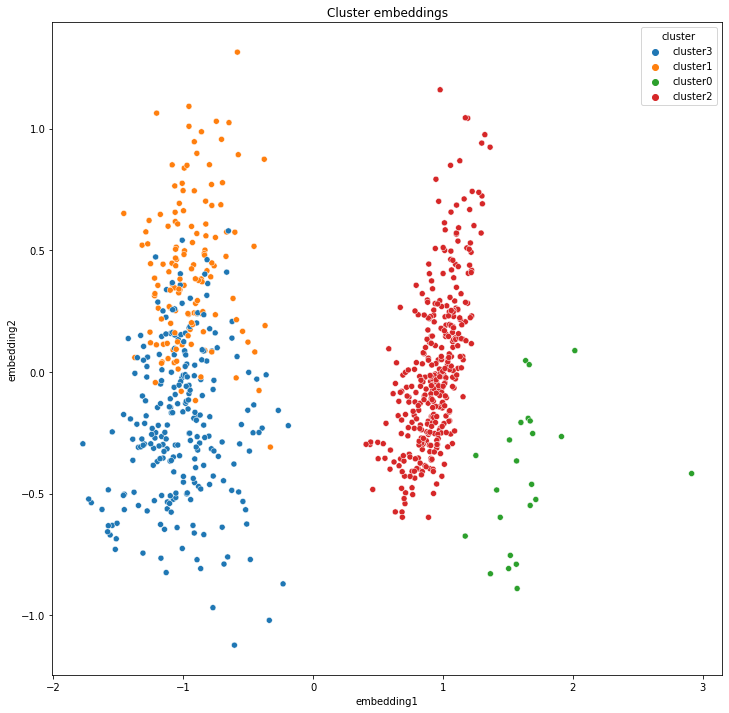

In [28]:
np.random.seed(0)
plt.figure(figsize=(12, 12))
plt.title("{} embeddings".format('cluster').capitalize())
ax = sns.scatterplot(data=plot_df, x="embedding1", y="embedding2", hue='cluster')


In [32]:
print(plot_df[plot_df['plants']=='Plant_Punica'])
print(plot_df[plot_df['cluster']=='cluster0'])

         plants  embedding1  embedding2   cluster
4  Plant_Punica    1.100513    0.262481  cluster2
                   plants  embedding1  embedding2   cluster
2         Plant_Lysihiton    2.915068   -0.417242  cluster0
78           Plant_Clivia    1.567210   -0.365514  cluster0
84       Plant_Fortunella    1.506268   -0.807683  cluster0
134        Plant_Anthemis    1.656566   -0.190436  cluster0
155          Plant_Rhapis    1.637195    0.046672  cluster0
262         Plant_Hatiora    1.912950   -0.265246  cluster0
269         Plant_Lithops    1.512637   -0.279279  cluster0
270         Plant_Genista    2.015990    0.087858  cluster0
275            Plant_Ixia    1.365874   -0.829069  cluster0
319     Plant_Chamaedorea    1.414012   -0.484877  cluster0
342          Plant_Cornus    1.571569   -0.889643  cluster0
401     Plant_Erythronium    1.171844   -0.674221  cluster0
448   Plant_Alternanthera    1.672050   -0.548382  cluster0
510  Plant_CarmonaEhretia    1.691429   -0.252843  cluster0
